In [14]:
# Download fully trained DeepFrag model.
!wget -q -O model.zip -L https://durrantlab.pitt.edu/apps/deepfrag/files/final_model_v2.zip
!unzip -q model.zip

In [15]:
# Download fragment fingerprints for inference.
!wget -q -O fingerprints.h5 -L https://durrantlab.pitt.edu/apps/deepfrag/files/fingerprints.h5

In [3]:
# Clone DeepFrag python package.
!git clone https://git.durrantlab.pitt.edu/jdurrant/deepfrag.git

Cloning into 'deepfrag'...
remote: Enumerating objects: 431, done.
remote: Counting objects: 100% (431/431), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 431 (delta 233), reused 415 (delta 226), pack-reused 0
Receiving objects: 100% (431/431), 34.04 MiB | 1.19 MiB/s, done.
Resolving deltas: 100% (233/233), done.


In [1]:
# pip install -U ProDy
# conda install -c rmg py3dmol
# pip install h5py
# pip install tqdm
# pip install numba
# conda install -c conda-forge openbabel

In [39]:
import sys
sys.path.append('./Downloads/deepfrag')
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [40]:
import torch
import prody
import py3Dmol
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import IPythonConsole
Draw.IPythonConsole.ipython_3d = True
import numpy as np
import time
import h5py
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
from leadopt.model_conf import LeadoptModel, DIST_FN
from leadopt import grid_util
from leadopt.data_util import REC_TYPER, LIG_TYPER
from leadopt import util

In [42]:
def to2d(x):
  '''Remove 3d coordinate info from a rdkit mol for display purposes.'''
  return Chem.MolFromSmiles(Chem.MolToSmiles(x, isomericSmiles=False))

def tosdf(x):
  '''Rdkit mol to SDF string.'''
  return Chem.MolToMolBlock(x)+'$$$$\n'

In [43]:
pwd

'/home/cree/deepfrag'

In [5]:
# Check whether example is in the TEST set (i.e. not seen during training or validation)
from config import moad_partitions
"5NEV" in moad_partitions.TEST

False

In [31]:
# Download the ligand/receptor complex from RCSB.
!wget -L https://files.rcsb.org/download/5NEV.pdb1.gz
!gzip -df 5NEV.pdb1.gz

--2021-07-06 18:22:10--  https://files.rcsb.org/download/5NEV.pdb1.gz
Resolving files.rcsb.org (files.rcsb.org)... 128.6.158.66
Connecting to files.rcsb.org (files.rcsb.org)|128.6.158.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195378 (191K) [application/octet-stream]
Saving to: ‘5NEV.pdb1.gz’

5NEV.pdb1.gz        100%[===================>] 190.80K   674KB/s    in 0.3s    

2021-07-06 18:22:11 (674 KB/s) - ‘5NEV.pdb1.gz’ saved [195378/195378]



In [5]:
# Use ProDy to split the complex into separate protein and ligand pdb files.
m = prody.parsePDB('./6q4drec.pdb')
rec = m.select('not (nucleic or hetatm) and not water')
#lig = m.select('resname 72L')

#prody.writePDB('./rec.pdb', rec)
#prody.writePDB('./lig.pdb', lig)

@> 2324 atoms and 1 coordinate set(s) were parsed in 0.07s.


In [8]:
# We need to use OpenBabel to infer bond order information since RDKit doesn't.
!obabel HHT.pdb -OHHT.sdf

*** Open Babel Warning  in parseAtomRecord
  Problems reading a HETATM or ATOM record.
  According to the PDB specification,
  columns 77-78 should contain the element symbol of an atom.
  but OpenBabel found ' *' (atom 11)
1 molecule converted


In [18]:
!cd ~

In [19]:
!pwd

/home/cree/Downloads


### Step 1: Load receptor and convert to coordinates and types

In this step we extract relevant atomic information from the receptor pdb file. Specifically, we need to generate a numpy array of atomic coordinates (x,y,z) and atomic "types". By default, this package uses a descriptive format for "types" including the atomc number, boolean indicators for aromaticity, hydrogen acceptor/donor and an unsigned char representation of the partial charge.
However, the final model uses the simple type scheme which only requires the atomic number. So we could simply extract the atomic number here and use a different rec_typer later on.

In [67]:
rec_coords, rec_types = util.load_receptor_ob('./6q4drec.pdb')

print('Coords (x,y,z):\n', rec_coords[:5])
print('Types (element, aro, hdon, hacc, charge):\n', rec_types[:5])

Coords (x,y,z):
 [[-12.011  -6.481 -44.106]
 [-11.707  -5.757 -45.432]
 [-12.283  -4.325 -45.544]
 [-11.593  -3.52  -46.124]
 [-12.025  -6.554 -46.7  ]]
Types (element, aro, hdon, hacc, charge):
 [[7. 0. 0. 0. 0.]
 [6. 0. 0. 0. 0.]
 [6. 0. 0. 0. 0.]
 [8. 0. 0. 0. 0.]
 [6. 0. 0. 0. 0.]]


### Step 2: Load ligand and generate fragments

Next we will load the ligand from the pdb file and generate a list of (parent, fragment) tuples.

In [10]:
## NB had to correct valence of N on line 14 and 46 of sdf file by hand:
#   -9.5190  -21.3900   23.2500 N   0  0  0  0  0  0  0  0  0  0  0  0
#      9 12  1  0  0  0  0

Generated 6 fragments


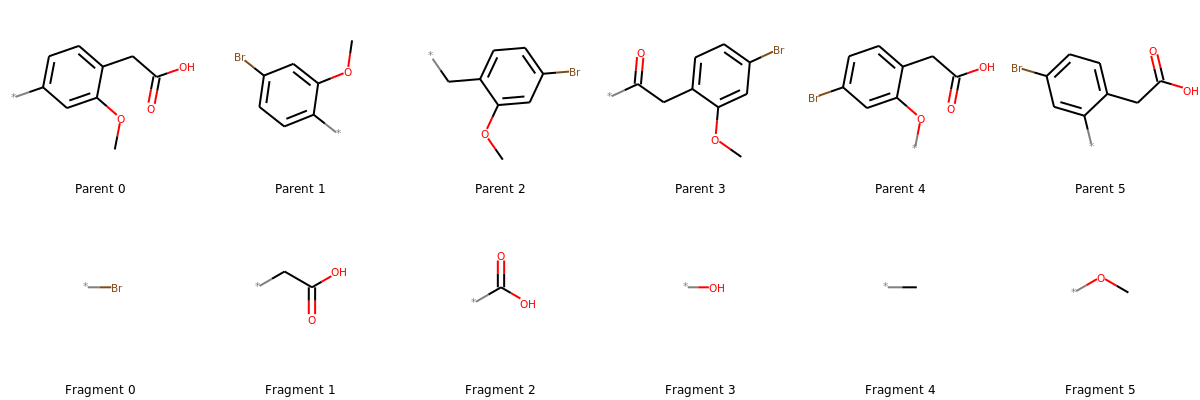

In [75]:
from rdkit.Chem import rdmolops

lig = Chem.MolFromMolFile('./6q4d_B_HHT.sdf')
ligs = rdmolops.GetMolFrags(lig, asMols = True)
lig = max(ligs, default=lig, key=lambda m: m.GetNumAtoms())

frags = util.generate_fragments(lig)

print('Generated %d fragments' % len(frags))

NUM = 6
Draw.MolsToGridImage(
    [to2d(x[0]) for x in frags[:NUM]] + [to2d(x[1]) for x in frags[:NUM]],
    legends=(
        ['Parent %d' % x for x in range(NUM)] 
        + ['Fragment %d' % x for x in range(NUM)]
    ),
    molsPerRow=NUM)

In [69]:
# Chem.FragmentOnBonds() will fragment all specified bond indices at once, and return a single molecule
# with all specified cuts applied. By default, addDummies=True, so empty valences are filled with dummy atoms:

In [70]:
def mol_with_atom_index(mol):
    atoms = mol.GetNumAtoms()
    tmp_mol = Chem.Mol(mol)
    for idx in range(atoms):
        tmp_mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber', str(tmp_mol.GetAtomWithIdx(idx).GetIdx()))
    return tmp_mol

In [83]:
print(Chem.MolToMolBlock(editedmol))


     RDKit          3D

 13 13  0  0  0  0  0  0  0  0999 V2000
    0.0000    0.0000    0.0000 R   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7030   -7.8450  -26.4180 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5090   -7.2420  -25.1910 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.5670   -7.9810  -24.0310 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7830   -9.3430  -24.0590 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.7780  -10.1580  -22.8130 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.0880  -10.4300  -22.1220 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0040   -9.2070  -26.4780 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.4110  -11.9670  -26.5110 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.2880  -11.2850  -25.2800 O   0  0  0  0  0  0  0  0  0  0  0  0
   -1.0080   -9.9600  -25.3270 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.0600  -11.2260  -21.1660 O   0  0  0  0  0  0  0  0  0  0  0  0
   -3.1080   -9.8300  -22.5030 O   0  0  0  0  0  0  0  0  0  0  0  0
  2  3  2  0
  2  8  1  0

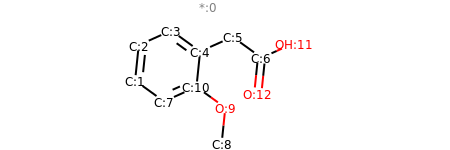

In [76]:
#replaces halogen with H
match = Chem.MolFromSmarts('[Br]')
repl = Chem.MolFromSmarts('[H]')
new_mol = Chem.ReplaceSubstructs(lig, match, repl)
new_molH = new_mol[0]

#removes Hs
new_mol = Chem.RemoveHs(new_molH)
new_mol



#combines wildcard with molecule, represented in 2D
combo = Chem.CombineMols(Chem.MolFromSmiles("*"), new_mol)
combo_2d = Chem.Mol(combo)
_ = AllChem.Compute2DCoords(combo_2d)
mol_with_atom_index(combo_2d)

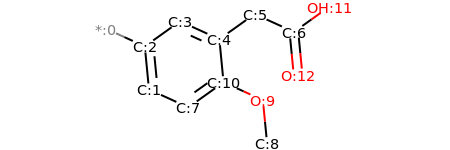

In [82]:
#atm_idx selects where the exit vector will be
atm_idx = 2
exit_vector = 0
edcombo = Chem.EditableMol(combo)
num_heavy_atoms = combo.GetNumHeavyAtoms()
edcombo.AddBond(atm_idx, exit_vector, order=Chem.rdchem.BondType.ZERO)
editedmol = edcombo.GetMol()
Chem.SanitizeMol(editedmol)
combo_2d = Chem.Mol(editedmol)
_ = AllChem.Compute2DCoords(combo_2d)
lig_new = mol_with_atom_index(combo_2d)
lig_list = [lig_new,lig_new]
mol_with_atom_index(combo_2d)

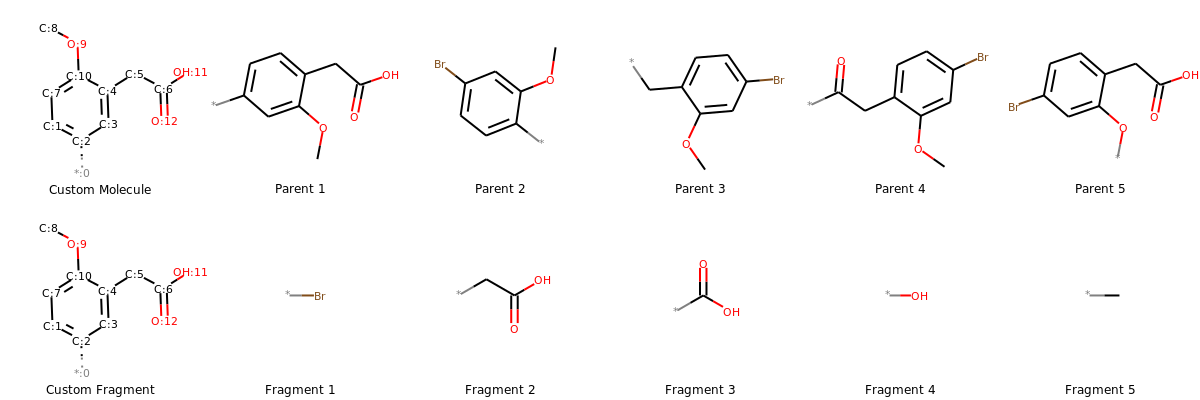

In [78]:
# insert custom molecule into list of fragments
frags.insert(0,lig_list)

a = ['Parent %d' % x for x in range(NUM)]
b = ['Fragment %d' % x for x in range(NUM)]
a[0], b[0] = 'Custom Molecule', 'Custom Fragment'

legend = [1,2,3,4,5]
Draw.MolsToGridImage(
    [to2d(x[0]) for x in frags[:NUM]] + [to2d(x[1]) for x in frags[:NUM]],
    legends=( a+b
    ), molsPerRow=NUM)

In [79]:
# Change this to select a different fragment. Custom fragment = 0.
# Custom fragment is added close to (0,0,0), Deepfrag's fragments are kept in place.
FRAG_IDX = 0

view = py3Dmol.view(width=800, height=800)

# Receptor.
view.addModel(open('./6q4drec.pdb', 'r').read(), 'pdb')
view.setStyle({'model': 0}, {'cartoon': {'color':'spectrum'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'white'})

# Parent.
view.addModel(tosdf(frags[FRAG_IDX][0]), 'sdf')
view.setStyle({'model': 1}, {'stick':{}})

# Fragment.
view.addModel(tosdf(frags[FRAG_IDX][1]), 'sdf')
view.setStyle({'model': 2}, {'stick':{'color': 'yellow'}})

view.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In this mode of operation, we will ask DeepFrag to predict a suitable replacement for the fragment above (highlighted in yellow). The network input will consist of the local receptor context and the "parent" molecule (the part of the ligand that is not the fragment).

### Step 3: Convert parent to coordinates and types

Like the receptor, we need to convert the parent portion of the ligand to an array of coordinates and types. Here we will also identify the "connection point" to use for fragment prediction. During training, the connection point is simply the atom on the parent ligand that the fragment is connected to. We provide a utility method to identify this by searching for the rdkit dummy atom type 0.

In [25]:
parent = frags[FRAG_IDX][0]

parent_coords = util.get_coords(parent)
parent_types = np.array(util.get_types(parent)).reshape((-1,1))
conn = util.get_connection_point(frags[FRAG_IDX][1])

print('Coords (x,y,z):\n', parent_coords[:5])
print('Types (element):\n', parent_types[:5])
print('Connection point: ', conn)

Coords (x,y,z):
 [[-2.61301033 -1.00692255  0.        ]
 [-2.7577978   0.48607329  0.        ]
 [-1.53721922  1.35796085  0.        ]
 [-0.17185315  0.73685256  0.        ]
 [ 1.04872544  1.60874012  0.        ]]
Types (element):
 [[6]
 [6]
 [6]
 [6]
 [6]]
Connection point:  [-4.12316387  1.10718158  0.        ]


### Step 4: Load DeepFrag Model & Fingerprints

We can load a pretrained DeepFrag model with LeadoptModel.load. This function expects a path to a model folder which contains args.json describing the model hyperparameters and voxel.pt containing the serialized weights of the model.
By default, this model will be loaded on the GPU, however we can pass a PyTorch device to the device parameter to load the model on the CPU instead.

In [26]:
USE_CPU = True

device = torch.device('cpu') if USE_CPU else torch.device('cuda')
print('Using CPU' if USE_CPU else 'Using GPU')

model = LeadoptModel.load('./final_model', device=device)

with h5py.File('./fingerprints.h5', 'r') as f:
  f_smiles = f['smiles'][()]
  f_fingerprints = f['fingerprints'][()].astype(np.float)

print('Loaded %d fingerprints' % len(f_smiles))

Using CPU
Loaded 5564 fingerprints


##### Note: Training-serving skew

To ensure the same configuration is used during training and inference, model hypeparameters are bundled with each model. This includes train-time constants such as learning rate and model architecture however it also includes grid generation parameters. These parameters are accessable through the model._args dict. This system enables model reflection and you can write scripts that look up configuration parameters at runtime. For example, in the cells below, we lookup grid generation parameters from the saved model to configure how to generate new grids at inference time.

In [27]:
for k in model._args:
  print('%s:' % k, model._args[k])

version: voxelnet
no_partitions: False
fragments: ./data/moad.h5
fingerprints: ./data/rdk10_moad.h5
learning_rate: 0.0001
num_epochs: 1000
test_steps: 400
batch_size: 16
grid_width: 24
grid_res: 0.75
fdist_min: None
fdist_max: 4
fmass_min: None
fmass_max: 150
ignore_receptor: False
ignore_parent: False
output_size: 2048
pad: False
blocks: [64, 64]
fc: [512]
use_all_labels: True
dist_fn: cos
loss: direct
point_radius: 1.75
point_type: 0
rec_typer: simple
acc_type: 0
lig_typer: simple


### Step 5: Generate Voxel Grids

Now we can generate grids. The grid generation code is implemented with Numba, a JIT CUDA compiler for Python. The first grid generation step may be slower as Numba needs to compile the CUDA kernel. Subsequent steps will be faster as the kernel can be reused.

In [28]:
start = time.time()
batch = grid_util.get_raw_batch(
    rec_coords, rec_types, parent_coords, parent_types,
    rec_typer=REC_TYPER[model._args['rec_typer']],
    lig_typer=LIG_TYPER[model._args['lig_typer']],
    conn=conn,
    num_samples=32,
    width=model._args['grid_width'],
    res=model._args['grid_res'],
    point_radius=model._args['point_radius'],
    point_type=model._args['point_type'],
    acc_type=model._args['acc_type'],
    cpu=USE_CPU
)
batch = torch.as_tensor(batch)
end = time.time()

print('Shape: ', batch.shape)
print('Batch generated in %0.3f seconds' % (end - start))

Shape:  torch.Size([32, 9, 24, 24, 24])
Batch generated in 27.567 seconds


##### (optional) visualize the grids
Here we plot one grid from the batch of 32. Each image in the figure below is a width x width slice of atomic density information. Each row represents a different channel. Each column represents a different x position.

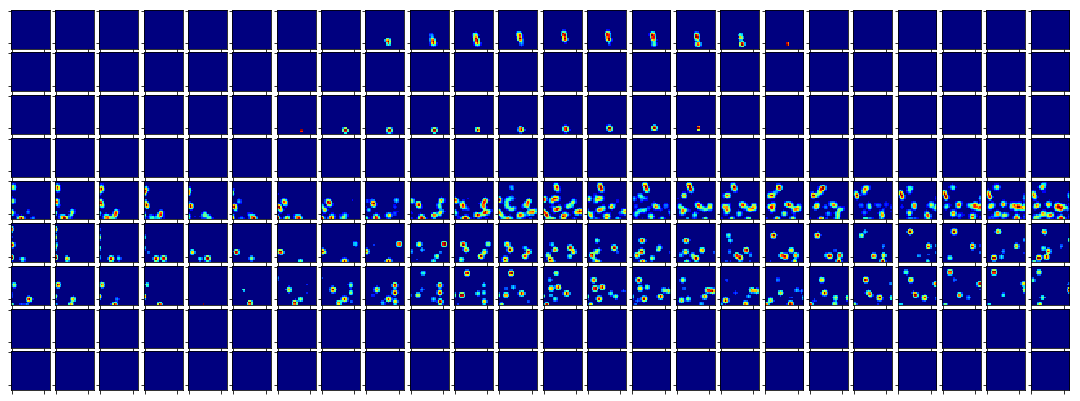

In [29]:
batch_n = batch.cpu().numpy()

IDX = 0
SCALE = 0.8

NLAYER = batch_n.shape[1]
NWIDTH = batch_n.shape[2]

plt.figure(figsize=(int(NWIDTH * SCALE), int(NLAYER * SCALE)))
for layer in range(NLAYER):
  for x in range(NWIDTH):
    ax = plt.subplot(NLAYER, NWIDTH, (layer * NWIDTH) + x + 1)
    plt.imshow(batch_n[IDX][layer][x], cmap='jet')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

plt.subplots_adjust(wspace=0.1, hspace=0.1)

### Step 6: Generate Predictions

We feed the voxel tensor to the model to obtain a prediction vector.
The voxel input is 5 dimensional with dimensions: (batch_idx, layer_idx, x, y, z).

In [30]:
start = time.time()
pred = model.predict(batch.float()).cpu().numpy()
end = time.time()

print('Generated prediction in %0.3f seconds' % (end - start))
print('Shape:', pred.shape)

Generated prediction in 0.675 seconds
Shape: (32, 2048)


##### (optional) visualize a prediction fingerprint
We can plot the fingerprint values as an image. This is fairly hard to interpret without comparing to other fingerprints.

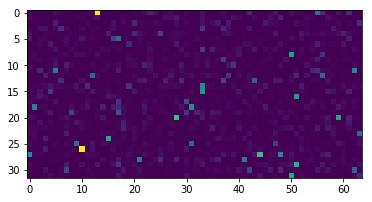

In [31]:
IDX = 0
fp = pred[IDX].reshape((32, 64))

plt.imshow(fp)

### Step 7: Compare to Fingerprint Library

To make sense of this generated fingerprint, we need to compare it to a fingerprint library.

Average FP shape: (2048,)
Top 16 fragments:


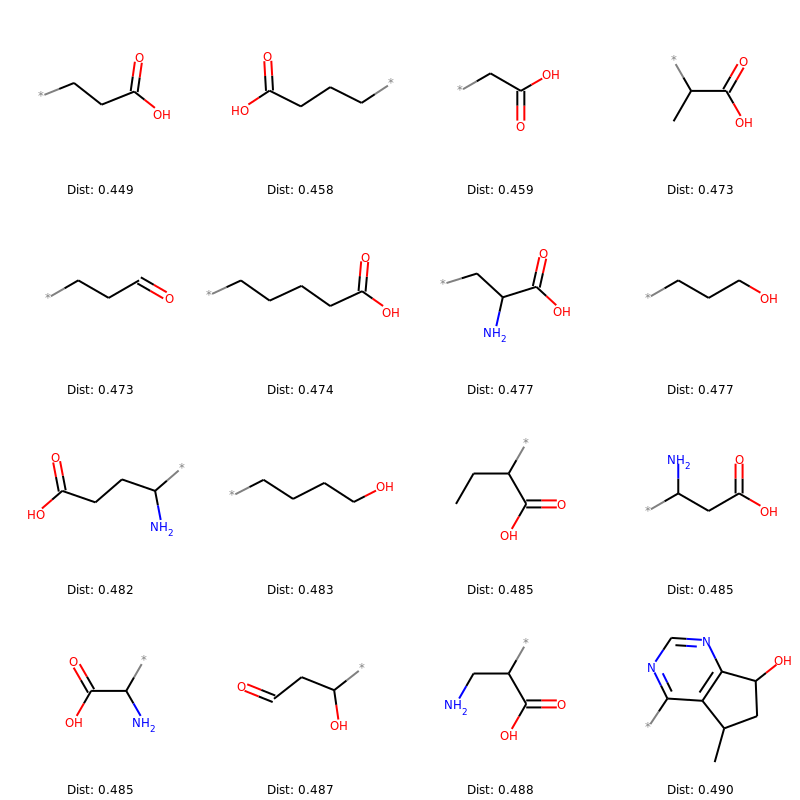

In [32]:
# Compute the average fingerprint.
avg_fp = np.mean(pred, axis=0)
print('Average FP shape:', avg_fp.shape)

# Grab the model distance function (in this case, cosine similarity).
dist_fn = DIST_FN[model._args['dist_fn']]

# The distance functions are implemented in pytorch so we need to convert our
# numpy arrays to a torch Tensor.
dist = dist_fn(
    torch.Tensor(avg_fp).unsqueeze(0),
    torch.Tensor(f_fingerprints))

# Pair smiles strings and distances.
dist = list(dist.numpy())
scores = list(zip(f_smiles, dist))
scores = sorted(scores, key=lambda x:x[1])

print('Top 16 fragments:')

mols = [Chem.MolFromSmiles(x[0]) for x in scores[:16]]
leg = ['Dist: %0.3f' % x[1] for x in scores[:16]]
Draw.MolsToGridImage(mols, molsPerRow=4, legends=leg)

### Step 8 (optional): Generate 3D embedding

In this step we will sample several conformations of the predicted ligand and visualize how it fits in the receptor pocket.

In [33]:
def geometric_embedding(fragment):
  """Generate a realistic 3D embedding of a fragment.

  Note: this method strictly optimizes the fragment conformation without respect
  to the receptor or parent molecule. For small fragments, the conformation will
  already be fairly fixed so this probably won't do much.
  
  Args:
  - fragment: rdkit molecule

  Returns:
  - an rdkit molecule with 3D coordinates
  """
  frag = to2d(fragment)

  # Temporarily replace dummy atoms with hydrogen so we get reasonable geometry.
  dummy_idx = [x.GetIdx() for x in fragment.GetAtoms() if x.GetAtomicNum() == 0]
  for idx in dummy_idx:
    frag.GetAtomWithIdx(idx).SetAtomicNum(1)

  # Minimize engergy.
  frag = Chem.AddHs(frag)
  cids = AllChem.EmbedMultipleConfs(frag, 50, pruneRmsThresh=1)
  for conf in cids:
    AllChem.UFFOptimizeMolecule(frag, confId=conf, maxIters=200)

  # Replace any dummy atoms.
  for idx in dummy_idx:
    frag.GetAtomWithIdx(idx).SetAtomicNum(0)

  return frag, cids

def get_connecting_atoms(mol):
  """Return the connection point atom (element 0), it's neighbor,
  and a neighbor of the neighbor (for defining dihedral)."""
  connectidx = [a.GetIdx() for a in mol.GetAtoms() if a.GetAtomicNum() == 0][0]
  atm = mol.GetAtomWithIdx(connectidx)
  nextatm = atm.GetNeighbors()[0]
  nextidx = nextatm.GetIdx()
  nextnextidx = [a for a in nextatm.GetNeighbors() if a.GetIdx() != connectidx][0].GetIdx()
  return connectidx, nextidx, nextnextidx

def embed_fragment(rec, parent, fragment):
  """Generate an embedding of the (parent/fragment) fusion molecule in the 
  context of a receptor.

  Args:
  - rec: An rdkit mol containing the receptor complex.
  - parent: An rdkit mol containing the parent molecule.
  - fragment: An rdkit mol containing the fragment molecule that should be
    attached to the parent.

  Returns:
  (ligand, energies, best_energy)

  - ligand: The optimized parent/fragment ligand as an rdkit mol.
  - energies: A list of predicted energies from sampling different conformations.
  - best_energy: The lowest energy from the sampled conformations.
  """
  energies = []

  Chem.SanitizeMol(rec)
  fragment, cids = geometric_embedding(fragment)

  # Find the dihedral
  paridx, parnext, parnextnext = get_connecting_atoms(parent)
  
  best_energy = np.inf
  best_mol = None

  # For each conformer...
  for cid in tqdm(cids, desc='Sampling conformations'):
    mol = Chem.RWMol(fragment, False, cid)

    # Align the connection point.
    fragidx, fragnext, fragnextnext = get_connecting_atoms(mol)
    Chem.rdMolAlign.AlignMol(
        mol, parent, atomMap=[(fragidx,parnext),(fragnext,paridx)])

    # Merge into new molecule.
    merged = Chem.RWMol(Chem.CombineMols(parent,mol))

    # Update fragment indices.
    fragidx += parent.GetNumAtoms()
    fragnext += parent.GetNumAtoms()
    fragnextnext += parent.GetNumAtoms()
    bond = merged.AddBond(parnext,fragnext,Chem.rdchem.BondType.SINGLE)
    merged.RemoveAtom(fragidx)
    merged.RemoveAtom(paridx)
    Chem.SanitizeMol(merged)

    # Update indices to account for deleted atoms.
    if fragnext > fragidx: fragnext -= 1
    if fragnextnext > fragidx: fragnextnext -= 1
    fragnext -= 1
    fragnextnext -= 1
    if parnext > paridx: parnext -= 1
    if parnextnext > paridx: parnextnext -= 1

    # Optimize the connection of the fragment (bond is wrong length).
    ff = AllChem.UFFGetMoleculeForceField(merged)
    for p in range(parent.GetNumAtoms()-1): # Don't include dummy atom.
      ff.AddFixedPoint(p) # Don't move parent.
    ff.Minimize()

    # Create a complex with the receptor.
    reclig = Chem.CombineMols(rec, merged)
    Chem.SanitizeMol(reclig)

    # Determine dihedral indices.
    l = fragnextnext+rec.GetNumAtoms()
    k = fragnext+rec.GetNumAtoms()
    j = parnext+rec.GetNumAtoms()
    i = parnextnext+rec.GetNumAtoms()

    # Sample the dihedral.
    for deg in tqdm(range(0,360,5), desc='Sampling dihedral angle'):
      Chem.rdMolTransforms.SetDihedralDeg(reclig.GetConformer(),i,j,k,l,deg)

      # Create forcefield for the whole complex.
      ff = AllChem.UFFGetMoleculeForceField(reclig,ignoreInterfragInteractions=False)

      # Fix everything but the fragment.
      for p in range(rec.GetNumAtoms()+parent.GetNumAtoms()-1):
        ff.AddFixedPoint(p)    
      energy = ff.CalcEnergy()

      energies.append(energy)
      if energy < best_energy:
        best_energy = energy
        best_mol = Chem.RWMol(reclig)

  # Extract the best ligand.
  ligatoms = set(range(rec.GetNumAtoms(), best_mol.GetNumAtoms()))
  ligbonds = [b.GetIdx() for b in best_mol.GetBonds() if b.GetBeginAtomIdx() in ligatoms and b.GetEndAtomIdx() in ligatoms]
  bestlig = Chem.PathToSubmol(best_mol, ligbonds)

  return bestlig, energies, best_energy

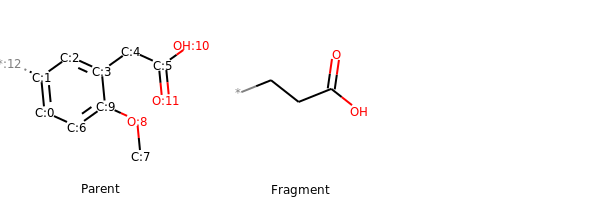

In [34]:
rec = Chem.MolFromPDBFile('6q4drec.pdb') # Load receptor into rdkit.
fragment = mols[0] # Pick the top-predicted fragment.

Draw.MolsToGridImage(
    [to2d(parent), to2d(fragment)],
    legends=['Parent', 'Fragment'])

Sampling conformations:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

(0, 10000)

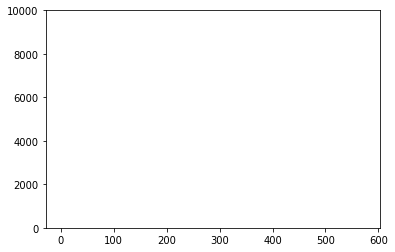

In [35]:
#embeds top mol
lig, energies, best_energy = embed_fragment(rec, parent, fragment)

plt.plot(energies)
plt.ylim(0,10000)

In [40]:
#WRITES TOP 10 TO SDF (previous cell looped over top 10 mols)
for i in range(10):
    lig, energies, best_energy = embed_fragment(rec, parent, mols[i])
    with open('frag33_top10.sdf','a') as f:
        f.write(tosdf(lig))
    print("Wrote pose number: ", i)

Sampling conformations:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Wrote pose number:  0


Sampling conformations:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Wrote pose number:  1


Sampling conformations:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Wrote pose number:  2


Sampling conformations:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Wrote pose number:  3


Sampling conformations:   0%|          | 0/2 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Wrote pose number:  4


Sampling conformations:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Wrote pose number:  5


Sampling conformations:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Wrote pose number:  6


Sampling conformations:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Wrote pose number:  7


Sampling conformations:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Wrote pose number:  8


Sampling conformations:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling dihedral angle:   0%|          | 0/72 [00:00<?, ?it/s]

Wrote pose number:  9


In [36]:
view = py3Dmol.view(width=800, height=800)

# Receptor.
view.addModel(Chem.MolToPDBBlock(rec), 'pdb')
view.setStyle({'model': 0}, {'cartoon': {'color':'spectrum'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'white'})

# Generated embedding.
view.addModel(tosdf(lig), 'sdf')
view.setStyle({'model': 1}, {'stick':{}})

# Original fragment.
view.addModel(tosdf(frags[FRAG_IDX][1]), 'sdf')
view.setStyle({'model': 2}, {'stick':{'color': 'yellow'}})

view.zoomTo({'model':1})

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [39]:
with open('frag31_custom.sdf','w') as f:
    f.write(tosdf(lig))

The fact the initial custom molecule (parent + fragment) is at (0,0,0), means embed_fragment() just embeds it there. For some reason editing the molecule removes the coordinate information, one possible fix is to use obfit

In [56]:
#output ligand
print(Chem.MolToMolBlock(lig))

HHT
     RDKit          3D

 13 13  0  0  0  0  0  0  0  0999 V2000
   -2.2451   -0.9515   -0.4172 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.3990   -1.3635   -1.4103 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.1426   -0.8543   -1.5854 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.3517    0.1234   -0.7508 C   0  0  0  0  0  0  0  0  0  0  0  0
    1.7162    0.7340   -0.8649 C   0  0  0  0  0  0  0  0  0  0  0  0
    2.6407    0.1308    0.1186 C   0  0  0  0  0  0  0  0  0  0  0  0
   -1.7451    0.0339    0.4171 C   0  0  0  0  0  0  0  0  0  0  0  0
   -0.8055    2.0405    2.1600 C   0  0  0  0  0  0  0  0  0  0  0  0
    0.0060    1.5546    1.1244 O   0  0  0  0  0  0  0  0  0  0  0  0
   -0.4892    0.5592    0.2643 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.0022   -1.7106   -0.1851 Br  0  0  0  0  0  0  0  0  0  0  0  0
    3.0241    0.7385    1.2751 O   0  0  0  0  0  0  0  0  0  0  0  0
    3.0898   -1.0351   -0.1456 O   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  2  0
  1  7  1

In [ ]:
print()